In [2]:
from collections import defaultdict
import csv
import sys
import numpy as np
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

csv.field_size_limit(10000000)

131072

In [58]:
IM_ID = '6120_2_2'
POLY_TYPE = '5'  # trees
path = 'C:/Users/ntste/Documents/Insight/Tree Data/'

# Load grid size
x_max = y_min = None
for _im_id, _x, _y in csv.reader(open(path + 'grid_sizes.csv')):
    if _im_id == IM_ID:
        x_max, y_min = float(_x), float(_y)
        break

# Load train poly with shapely
train_polygons = None
for _im_id, _poly_type, _poly in csv.reader(open(path + 'train_wkt_v4.csv')):
    if _im_id == IM_ID and _poly_type == POLY_TYPE:
        train_polygons = shapely.wkt.loads(_poly)
        break

# Read image with tiff
im_rgb = tiff.imread(path + 'three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
im_size = im_rgb.shape[:2]

In [59]:
def get_scalers():
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

x_scaler, y_scaler = get_scalers()

train_polygons_scaled = shapely.affinity.scale(
    train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

In [62]:
def mask_for_polygons(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

train_mask = mask_for_polygons(train_polygons_scaled)

[]


In [63]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2080922fa90>)

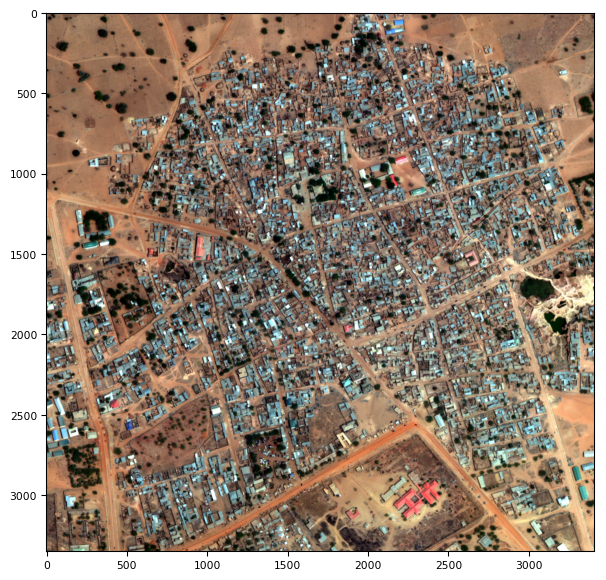

In [64]:
import matplotlib.pyplot
tiff.imshow(255 * scale_percentile(im_rgb))

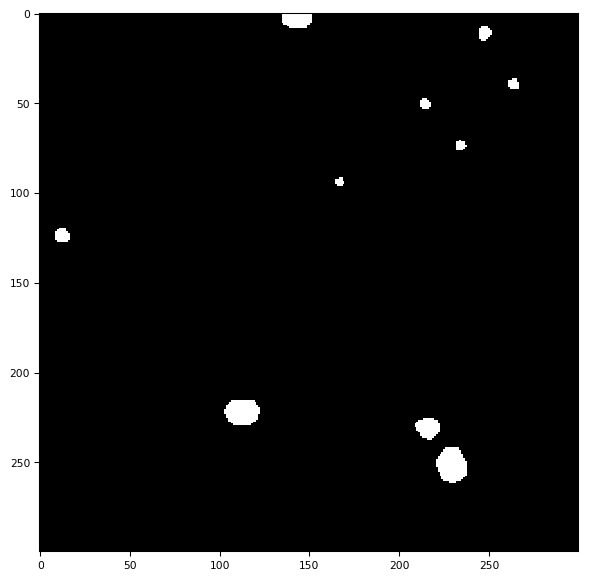

In [65]:
def show_mask(m):
    # hack for nice display
    tiff.imshow(255 * np.stack([m, m, m]));
show_mask(train_mask[2900:3200,2000:2300])

In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score

xs = im_rgb.reshape(-1, 3).astype(np.float32)
ys = train_mask.reshape(-1)
pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log'))

print('training...')
# do not care about overfitting here
pipeline.fit(xs, ys)
pred_ys = pipeline.predict_proba(xs)[:, 1]
print('average precision', average_precision_score(ys, pred_ys))
pred_mask = pred_ys.reshape(train_mask.shape)

training...


C:\Users\ntste\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


average precision 0.6872760581589186


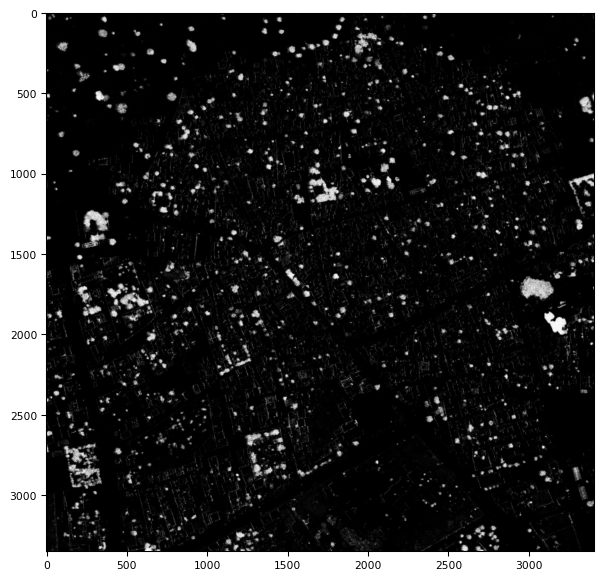

In [40]:
#show_mask(color_corrected_predmask[2900:3200,2000:2300])
threshold = 0.3
pred_binary_mask = pred_mask >= threshold
#color_corrected_predmask = pred_binary_mask*(im_rgb[:,:,1]/im_rgb[:,:,2])
#show_mask(color_corrected_predmask[2900:3200,2000:2300])
#threshold = 1.0
#pred_bindary_mask = color_corrected_predmask >= threshold
show_mask(pred_mask)

<class 'numpy.ndarray'>
(3348, 3403)


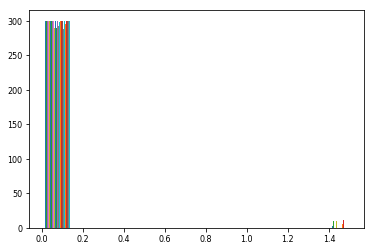

In [30]:
import matplotlib.pyplot as plt

plt.hist(color_corrected_predmask[2900:3200,2000:2300])
print(type(pred_mask))
print(pred_mask.shape)


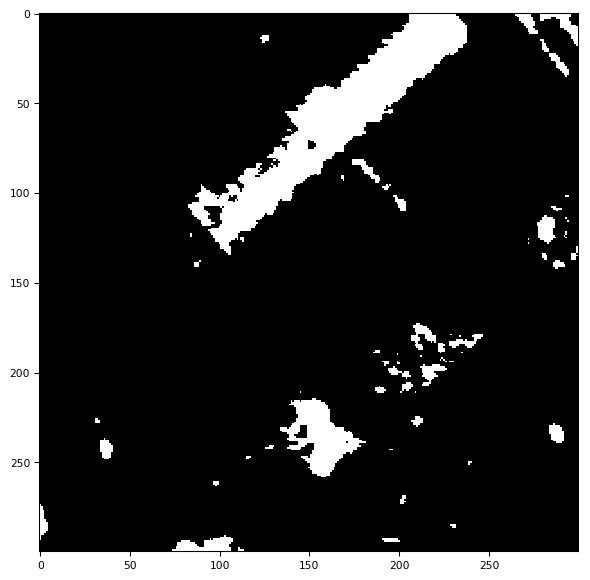

In [23]:
threshold = 0.3
pred_binary_mask = pred_mask >= threshold
show_mask(pred_binary_mask[2900:3200,2000:2300])

In [34]:
# check jaccard on the pixel level
tp, fp, fn = (( pred_binary_mask &  train_mask).sum(),
              ( pred_binary_mask & ~train_mask).sum(),
              (~pred_binary_mask &  train_mask).sum())
print('Pixel jaccard', tp / (tp + fp + fn))

Pixel jaccard 0.5210394841308262


In [35]:
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(((mask == 1) * 255).astype(np.uint8),cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

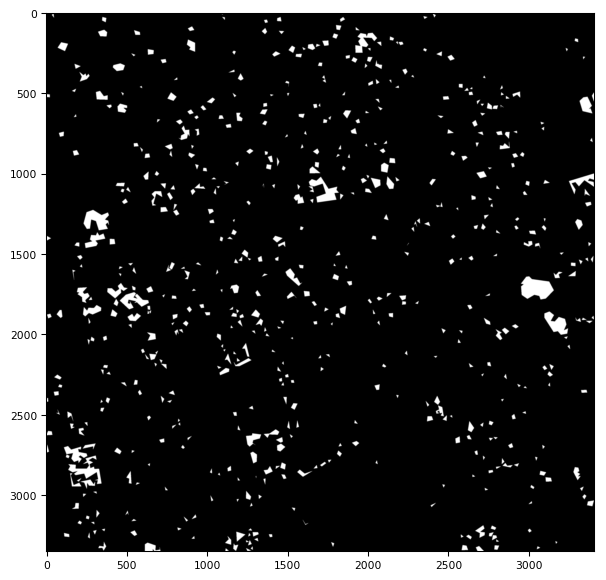

In [38]:
pred_polygons = mask_to_polygons(pred_binary_mask)
pred_poly_mask = mask_for_polygons(pred_polygons)
show_mask(pred_poly_mask)

'\nxs = im_rgb.reshape(-1, 3).astype(np.float32)\npred_ys = pipeline.predict_proba(xs)[:, 1]\npred_mask = pred_ys.reshape(train_mask.shape)\nthreshold = 0.3\npred_binary_mask = pred_mask >= threshold\nshow_mask(pred_binary_mask[2900:3200,2000:2300])\npred_polygons = mask_to_polygons(pred_binary_mask)\npred_poly_mask = mask_for_polygons(pred_polygons)\nshow_mask(pred_poly_mask[2900:3200,2000:2300])\n'

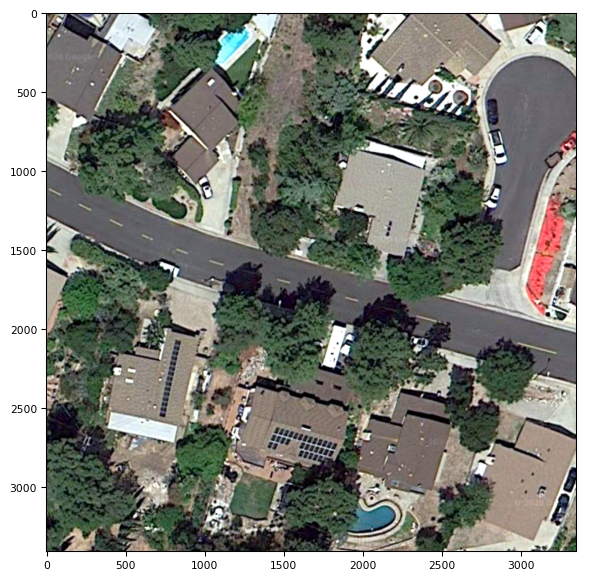

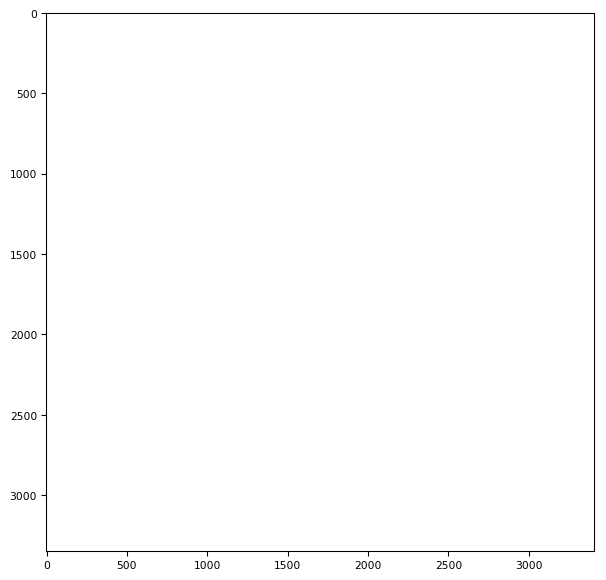

In [55]:
path = 'C:/Users/ntste/Documents/Insight/Tree Data/SAS Output/test4_subset_tiff.tif'
im_rgb = tiff.imread(path).transpose([1, 2, 0])
tiff.imshow(255 * scale_percentile(im_rgb))
#IM_ID = '6120_2_1'
#POLY_TYPE = '5'  # trees
#path = 'C:/Users/ntste/Documents/Insight/Tree Data/'
#im_rgb = tiff.imread(path + 'three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
#tiff.imshow(255 * scale_percentile(im_rgb))


xs = im_rgb.reshape(-1, 3).astype(np.float32)
pred_ys = pipeline.predict_proba(xs)[:, 1]
pred_mask = pred_ys.reshape(train_mask.shape)
threshold = 0.3
pred_binary_mask = pred_mask >= threshold
show_mask(pred_binary_mask)
#plt.hist(pred_binary_mask[2900:3200,2000:2300])

"""
xs = im_rgb.reshape(-1, 3).astype(np.float32)
pred_ys = pipeline.predict_proba(xs)[:, 1]
pred_mask = pred_ys.reshape(train_mask.shape)
threshold = 0.3
pred_binary_mask = pred_mask >= threshold
show_mask(pred_binary_mask[2900:3200,2000:2300])
pred_polygons = mask_to_polygons(pred_binary_mask)
pred_poly_mask = mask_for_polygons(pred_polygons)
show_mask(pred_poly_mask[2900:3200,2000:2300])
"""